# Generating contact rate predictions

## Goals

This notebook goes over how to generate predictions for the number of contacts of RNA with a set of genomic intervals.
We'll use three different models : 

1. ChiP-seq-like model : the contact rate is determined by the intergrated accessibility / charseq-ability within the genomic interval. In an ideal world were all regions have equal charseq-ability, this would be equivalent to having a contact rate proportional to the size of the genomic interval.
2. Distance from source model : the contact rate is determined by the distance between the source RNA and the target genomic interval. 
3. Combination of 1 and 2. In other words, the contact rate is determined by the distance between the source RNA and target genomic interval, and is also modulated by accessibility.

Note that models 2 and 3 apply to CIS contacts only (i.e. contacts between and RNA and its source chromosome), as there is no notion of 1D distance for TRANS contacts (contacts between an RNA and loci on chromosomes that are not the source chromosome for the RNA)  

The end goal is to compare for each genomic interval the oberved number of contacts, to the expected number of contacts according to either one of these models, so as to identify which genomic intervals have an excess of counts. The will be flagged as significant RNA-locus interactions. 

In this example we use 1Mb tiling of the genome as the genomic intervals but we'd want to do that on more interesting intervals later, like gene bodies for example. 

## Setup

In [1]:
from charmodels.prepare_data.RDloader import load_RD_data
import pandas as pd
from chartools import core as cc

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Load charseq dataset,  this time we need to load the RNA side of the data, as well as the decay models (loadmodels=True) and the charseq-ability bacground models (loadbkg=True)

In [3]:
chardata = load_RD_data(cleaned_up=True, loadrna=True, loaddna=True, loadbkg=True, loadmodels=True)
genes = chardata['genes']

100%|██████████| 9/9 [00:14<00:00,  1.61s/it]                     


Get the DNA side of the data, for the ES cells, exons+introns combined (all)

In [4]:
dna = chardata['dna']['ES']['all']

Load the genomic intervals of interest as a dataframe

In [5]:
reg_bed = '/oak/stanford/groups/astraigh/charseq2.0/genomes/hsapiens/grch38_foralign/resources/windows/chr1-22X_1Mbp.4cols.bed'
regs_df = pd.read_csv(reg_bed, sep='\t', names=['chr','start','stop','name'])

Make the projector for the DNA side of the data to be able to get the counts integrated over the intervals

In [6]:
pr = dna.df_to_shelf(regs_df, feature_info_id='name')

ok


Let's look at PVT1 only to speed things up. Could look at more genes if we wanted to.

In [7]:
dna_PVT1 = dna.select_annots(genes.loc[genes['name']=='PVT1'].index.to_list())

Get the counts withing the intervals

In [8]:
dna_PVT1_1Mbp = dna_PVT1.project(pr)

How many contacts in cis and trans?

In [10]:
_, _, N_PVT1 = dna_PVT1_1Mbp.cis_trans()
N_PVT1

,Ncis,Ntrans
ENSG00000249859.9,110274,57677


In [11]:
_, _, N_PVT1_v2 = dna_PVT1.cis_trans()
N_PVT1_v2

,Ncis,Ntrans
ENSG00000249859.9,110274,57677


## Model 1

The charseq-ability profile (I call it background but this is not the best terminology...) is stored in the chartable `chardata['bkg']['ES']['all']`, it is just the total signal from all the TRANS acting mRNAs 

In [12]:
bkg = chardata['bkg']['ES']['all']

In [13]:
bkg.N_bychr().toarray() # total number of counts going into the backgroun by chromosme

array([[2201292, 1430877, 1480127, 1492980, 1009467, 1048485,  986163,
        1004383, 1069878,  867540,  704130, 2088888,  869922,  440746,
         462556, 1826976, 1698756, 1641633, 1659703, 1467091, 1394467,
        1206856,  985232]])

When using this profile for predcitions, it will be normalized by chromosome by chromosome, so that the sum of the counts on each chromosome is 1. No need to worry about that later as this is done internally but it looks like this

In [14]:
bkg_normalized = bkg.normalize_row_bychr()
bkg_normalized.counts #23 rows, one per chromosome

<23x7786210 sparse matrix of type '<class 'numpy.float64'>'
	with 6499478 stored elements in Compressed Sparse Row format>

In [15]:
bkg_normalized.N_bychr().toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0.,

In [16]:
bkg_normalized_1Mbp = bkg_normalized.project(pr)

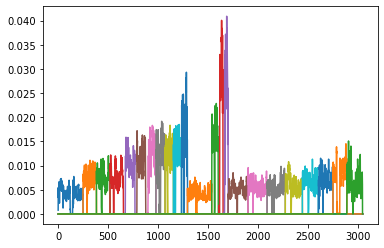

In [17]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
for i in range(bkg_normalized_1Mbp.counts.shape[0]):
    ax.plot(bkg_normalized_1Mbp.counts[i,:].toarray().ravel())

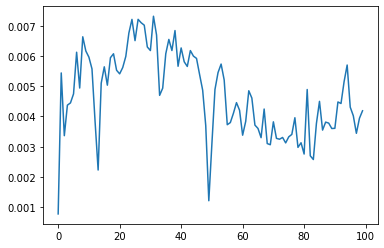

In [122]:
fig, ax = plt.subplots(1,1)
ax.plot(bkg_normalized_1Mbp.counts[0,0:100].toarray().ravel())

We can use this background model directly to predict the counts according to model 1. Note that even though the result is stored as a chartable with the data within it stored as a sparse matrix, the result is not sparse because the charseq-ability profile is almost never zero. 

In [18]:
dna_PVT1_1Mbp_pred1 = dna_PVT1.predict_trans_withinGI_v2(bkg, pr)

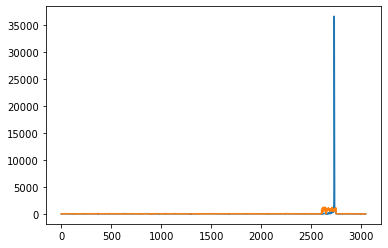

In [19]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel())
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel())

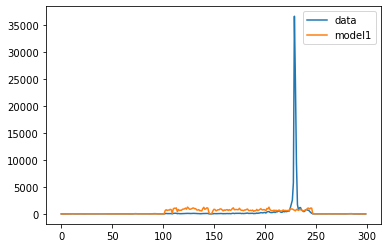

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel()[2500:2800], label='data')
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel()[2500:2800], label='model1')
ax.legend()

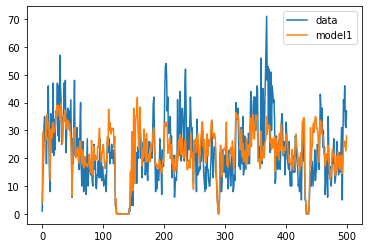

In [22]:
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel()[0:500], label='data')
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel()[0:500], label='model1')
ax.legend()

## Model 2

To use model 2, we need the RNA side of the data, as we need to know where the RNA is coming from to predcit how many counts we see at a given distance from the RNA. Note that "where the RNA is coming from" is actually where the RNA aligns, not the promoter of the gene. This makes the predcition quite slow because each count is handled one by one, but I was worried we might need that for long genes where the 3' and 5' end might be seprated by >100kb. Might be ok to use a simple model using the promoter position to calculate distance for prediction far from the source, but I haven't implemented that.

In [23]:
# get RNA side data for PVT1
rna_PVT1=chardata['rna']['ES']['all'].select_annots(genes.loc[genes['name']=='PVT1'].index.to_list())

# create projector for RNA onto the 1Mb bins
pr_RNA=chardata['rna']['ES']['all'].df_to_shelf(regs_df, feature_info_id='name')

ok


Get expected signal for PVT1 based on decay profile model (contact frequency vs distance). The decay profile model is stored in `chardata['cismodel']['ES']['exons']`

In [24]:
decay_model = chardata['cismodel']['ES']['exons']
decay_model.keys()

dict_keys(['bins', 'chi', 'rho', 'dchi'])

`decay_model[chi]` contains the cumulative distribution of contacts as a function of the signed distance from source (RNA alignment) to target (DNA alignment position), where the sign is relative to the gene orientation. This distribution is used to predict the number of contact expected from a given RNA at any position on the genome. Note that there is one decay model per chromosome, as it has to sum to one across the chromosome length (which is different for each chromosome)

Text(0, 0.5, 'Cumulative distribution')

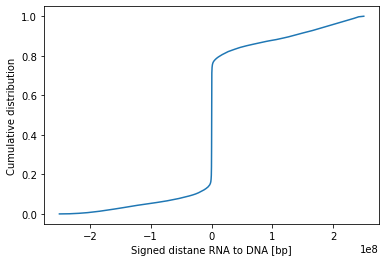

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(decay_model['bins'], decay_model['chi'][0][0:-1])
ax.set_xlabel('Signed distane RNA to DNA [bp]')
ax.set_ylabel('Cumulative distribution')
#ax.set_xscale('log')

A more standard representation of the decay model is as a contact density (rather than cumulative distribution), as a function of distance. This is stored in rho, but the orientation is preserved, so we have one positive and one negative decay curve.

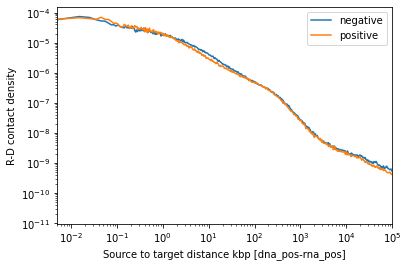

In [26]:
bins = decay_model['bins']
bins_centers = (bins[0:-1]+bins[1:])/2
nb = len(bins_centers)
nn = int(nb/2)
bins_pos = bins_centers[nn:]



fig, axs = plt.subplots(1, 1)
#axs.plot(bins_centers/1000+1e-4,  decay_model['rho'][0][1:(len(bins_centers)+1)], label='positive')
axs.plot(bins_pos/1000,  decay_model['rho'][0][len(bins_pos):-2], label='negative')
axs.plot(bins_pos/1000,  np.flip(decay_model['rho'][0][0:len(bins_pos)]), label='positive')

#axs.plot(bins_centers/1000, profiles_allchrI['xn'], label=t)


axs.set_xlim([bins_pos[0]/1000,100000])
#axs.axvline([0], color='k', linestyle=':')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('Source to target distance kbp [dna_pos-rna_pos]')
axs.set_ylabel('R-D contact density')
axs.legend()

The `predict_cis_withinGI` (Predict Cis contacts within genomic interval, bad function naming at the moment...) uses the decay model and the position of the rna (stored in the rna equivalent of the DNA chartable), to make predicted counts with the genomic intervals of interest. We need to pass it `chardata['gene_strand_dict']` which contains information about the strand for every gene (eventually should go in the genes dataframe and be pulled from there), since all the distances are signed.

**This function is quite slow so better to call it on only on a few genes at a time, not the entire `chardata['rna']` table. Here, we make the predcition for PVT1 only but we could have more genes**

In [27]:
dna_PVT1_1Mbp_pred2_CIS = rna_PVT1.predict_cis_withinGI(decay_model, pr_RNA, gene_strand_dict=chardata['gene_strand_dict'])

1.14829143764835


The resulting prediction looks like this

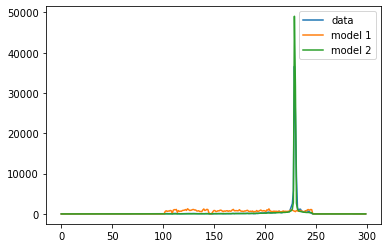

In [28]:
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel()[2500:2800], label='data')
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel()[2500:2800], label='model 1')
ax.plot(dna_PVT1_1Mbp_pred2_CIS.counts.toarray().ravel()[2500:2800], label='model 2')
ax.legend()

** Note This is only for the CIS contacts, we use model 1 for TRANS so we can add things up **

In [29]:
dna_PVT1_1Mbp_pred2 = dna_PVT1_1Mbp_pred2_CIS.copy(copydata=True)
_, dna_PVT1_1Mbp_pred1_TRANS, _ = dna_PVT1_1Mbp_pred1.cis_trans()
dna_PVT1_1Mbp_pred2.counts = dna_PVT1_1Mbp_pred2.counts + dna_PVT1_1Mbp_pred1_TRANS.counts

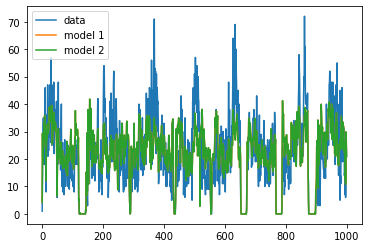

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel()[0:1000], label='data')
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel()[0:1000], label='model 1')
ax.plot(dna_PVT1_1Mbp_pred2.counts.toarray().ravel()[0:1000], label='model 2')
ax.legend()

## Model 3

This one is handled by this scratchy function, which should be added to the chartable_binned class

In [31]:
def flat_field(cts, b, prj, N_df, regdoms_df=None, count_zeros=True):
    
    bkg_mat=b.normalize_row_bychr().project(prj).sum(axis=0).counts.toarray().ravel()
            
    
    dvec=None
    dvec_out=None
    
    if regdoms_df is None: # use background "slots"
        b2=b.copy(copydata=True)
        if count_zeros:
            b2.counts.data=np.ones(b.counts.data.shape, dtype=b.counts.dtype)
        else:
            b2.counts.data=np.minimum(b2.counts.data, 1)
        
        bkg_mat2=b2.normalize_row_bychr().project(prj).sum(axis=0).counts.toarray().ravel()
        
        isz=bkg_mat2==0
        bkg_mat2[isz]=1
        dvec=bkg_mat/bkg_mat2
        dvec[isz]=1.0
        bkg_mat2[isz]=0
        dvec_out=(1.0-bkg_mat)/(1.0-bkg_mat2)
        dvec_out[isz]=1.0
        
    else:
        regdoms_df2=regdoms_df.loc[cts.bins_LUT]
    
        Ltotvec=cts.chr_len_vec[cts.annot_chr]
        delta=(regdoms_df2['stop']-regdoms_df2['start']).values
        Lvec=cts.chr_len_vec[regdoms_df2['chr'].map(cts.chr_dict).values]
    
        delta=delta/Lvec
    
        dvec=bkg_mat/delta
        dvec_out=(1.0-bkg_mat)/(1.0-delta)
        
        
    
    Nvec=N_df['Ncis'].loc[cts.annot_LUT].values
    data=cts.counts.data
    indices=cts.counts.indices
    indptr=cts.counts.indptr
    
    Ndata=np.zeros(len(data))
    for i in range(len(indptr)-1):
        Ndata[indptr[i]:indptr[i+1]]=Nvec[i]
    
    
    Bdata=dvec[indices]
    BdataOUT=dvec_out[indices]
    

    #print(Bdata)

    data_corr=(data*Bdata) * (Ndata/((Ndata-data)*BdataOUT+data*Bdata))
    cts_flat=cts.copy(copydata=True)
    
    cts_flat.counts.data=data_corr
    
    return cts_flat, dvec, dvec_out
    

In [33]:
_, _, N_df = dna_PVT1.cis_trans()

dna_PVT1_1MBp_pred3_CIS, _, _ = flat_field(dna_PVT1_1Mbp_pred2, bkg, pr, N_df, regdoms_df=regs_df)


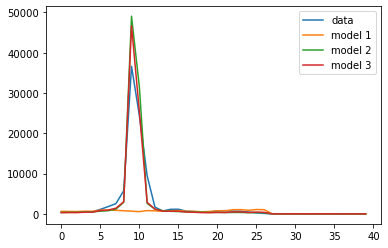

In [34]:
fig, ax = plt.subplots(1,1)
ax.plot(dna_PVT1_1Mbp.counts.toarray().ravel()[2720:2760], label='data')
ax.plot(dna_PVT1_1Mbp_pred1.counts.toarray().ravel()[2720:2760], label='model 1')
ax.plot(dna_PVT1_1Mbp_pred2.counts.toarray().ravel()[2720:2760], label='model 2')
ax.plot(dna_PVT1_1MBp_pred3_CIS.counts.toarray().ravel()[2720:2760], label='model 3')
ax.legend()